# FEATURES
## Analysis
#### Luciano De Bortoli | Ingeniería de Sonido
<img src="logo.jpg" alt="Drawing" align="left" style="width: 300px;"/>

In [98]:
import os
import csv
import librosa
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

In [134]:
def load_audio(audio_path):
    audio, fs = librosa.core.load(audio_path, sr=48000, mono=True)
    return audio

def get_mfcc(audio):
    return librosa.feature.mfcc(y=audio,sr=48000,hop_length=1024,n_mfcc=50)

def get_mels(audio):
    return librosa.feature.melspectrogram(y=audio,sr=48000, n_fft=2048, hop_length=1024, power=2.0)

def get_rms(audio):
    return librosa.feature.rmse(y=audio, frame_length=2048, hop_length=1024, center=True, pad_mode='reflect')

def get_spectral_centroid(audio):
    return librosa.feature.spectral_centroid(y=audio,sr=48000, n_fft=2048, hop_length=1024)

def get_spectral_bandwidth(audio):
    return librosa.feature.spectral_bandwidth(y=audio,sr=48000, n_fft=2048, hop_length=1024, p=2)

def get_spectral_contrast(audio):
    return librosa.feature.spectral_contrast(y=audio,sr=48000, n_fft=2048, hop_length=1024,fmin=200.0, n_bands=6, quantile=0.02)

def get_spectral_flatness(audio):
    return librosa.feature.spectral_flatness(y=audio, n_fft=2048, hop_length=1024, amin=1e-10, power=2.0)

def get_spectral_rolloff(audio):
    return librosa.feature.spectral_rolloff(y=audio,sr=48000, n_fft=2048, hop_length=1024, roll_percent=0.85)

def get_zero_crossing_rate(audio):
    return librosa.feature.zero_crossing_rate(y=audio, frame_length=2048, hop_length=1024, center=True)

def feature_extract(audio, feature_type):
    if feature_type=='mfcc'                 : return get_mfcc(audio)
    if feature_type=='mels'                 : return get_mels(audio)
    if feature_type=='rms'                  : return get_rms(audio)
    if feature_type=='spectral_centroid'    : return get_spectral_centroid(audio)
    if feature_type=='spectral_bandwidth'   : return get_spectral_bandwidth(audio)
    if feature_type=='spectral_contrast'    : return get_spectral_contrast(audio)
    if feature_type=='spectral_flatness'    : return get_spectral_flatness(audio)
    if feature_type=='spectral_rolloff'     : return get_spectral_rolloff(audio)
    if feature_type=='zero_crossing_rate'   : return get_zero_crossing_rate(audio)

def save_csv(data,labels,path):
    with open(path,'w',newline='') as csvfile:
        writer=csv.writer(csvfile,delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for index, row in enumerate(data):
            writer.writerow([labels[index],*row])

def load_csv(path):
    data = []
    with open(path, 'r') as csvFile:
        reader = csv.reader(csvFile)
        for row in reader:
            data.append(row)
        csvFile.close()  
    return data

def read_analysis(path):
    data = load_csv(path)
    labels=[]
    for label in range(len(data)):
        labels.append(data[label].pop(0))
    for i in range(len(data)):
        for j in range(len(data[0])):
            data[i][j]=float(data[i][j])     
    return data, labels

def export_analysis(data,feature_type,labels,save_dir):
    if not os.path.isdir(save_dir): os.mkdir(save_dir)
    save_path = os.path.join(save_dir,feature_type+".csv")
    save_csv(data=data,labels=labels,path=save_path)
    
def dataset_feature_analysis(feature_selection,main_dir):
    for feature_type in feature_selection:
        folders = os.listdir(main_dir)
        all_features_mean = []
        all_features_std = []
        for folder in folders:
            print("Processing","Feature:",feature_type,"| Class:",folder," "*20,end='\r')
            files = os.listdir(os.path.join(main_dir,folder))
            folder_features_mean = []
            folder_features_std = []
            for file in files:
                audio = load_audio(os.path.join(main_dir,folder,file))
                features = feature_extract(audio,feature_type)
                folder_features_mean.append(np.mean(features,axis=1))
                folder_features_std.append(np.std(features,axis=1))
            all_features_mean.append(np.mean(folder_features_mean,axis=0))
            all_features_std.append(np.mean(folder_features_std,axis=0))
        export_analysis(data=all_features_mean,feature_type=feature_type,labels=folders,save_dir="feature_means")
        export_analysis(data=all_features_std,feature_type=feature_type,labels=folders,save_dir="feature_stds")
    print("Finished"," "*40)
    
def plot_features(means=None,stds=None,fig_name="new_figure",labels=None, colors=None,xlim=None,ylim=None,legend_lim=None):
    plt.rc('font',   size=10)        # controls default text sizes
    plt.rc('axes',   titlesize=14)   # fontsize of the axes title
    plt.rc('axes',   labelsize=16)   # fontsize of the x and y labels
    plt.rc('xtick',  labelsize=14)   # fontsize of the tick labels
    plt.rc('ytick',  labelsize=14)   # fontsize of the tick labels
    plt.rc('legend', fontsize=13)    # legend fontsize
    plt.rc('figure', titlesize=10)   # fontsize of the figure title
    save_dir="feature_figures"
    if not os.path.isdir(save_dir): os.mkdir(save_dir)
    plt.figure(figsize=(12,5))   
    if len(means[0])==1:
        plt.bar(labels,np.squeeze(means),color=[1,1,1])
        plt.errorbar(x=labels, y=means, yerr=np.squeeze(stds), color='darkorange', markersize=20,
                     fmt='_',ecolor=[0.6,0.4,0.8],elinewidth=0.5,capsize=10,capthick=2)
        plt.xlabel("Clases")
        plt.ylabel(fig_name)
        plt.xticks(rotation='vertical')
    else :
        if len(means[0])==128:xaxis = librosa.mel_frequencies()
        else:xaxis = np.linspace(0,20000,len(means[0]))
        if colors == None :colors = [np.random.uniform(0.2,1,3) for _ in range(len(labels))]
        z_pos = list(np.linspace(len(means)-1,0,len(means)))
        styles = cycle(['-'])
        for index, class_means in enumerate(means):
            plt.plot(xaxis,class_means,marker='o',linestyle=next(styles),linewidth=1,markersize=4,color=colors[index],zorder=z_pos[index])    
        plt.xlabel("Frecuencia [Hz]")
        plt.ylabel(fig_name)
        plt.xlim(xlim)
        plt.ylim(ylim)
        #plt.xscale('log')
        #plt.xticks(xaxis)
        if not legend_lim == None: labels = labels[legend_lim[0]:legend_lim[1]]
        plt.legend(labels,loc="right", bbox_to_anchor=(1.4, 0.5, 0.2, 0.05),ncol=1)
    plt.grid(color=[0.9,0.9,0.9],linestyle='-.')
    plt.tight_layout()
    filename=fig_name+".png"
    plt.savefig(os.path.join(save_dir,filename),dpi=300,bbox_inches='tight')

In [ ]:
# RUN ANALYSYS:
feature_selection=[
    'spectral_centroid',
    'spectral_bandwidth',
    'spectral_flatness',
    'spectral_rolloff',
    'zero_crossing_rate',
    'spectral_contrast' ,
    'rms',
    'mfcc',
    'mels',
]
main_dir = "J:\\DataOffline\\Datasets\\SOUND_SCENES_AUDIO_HPF"
dataset_feature_analysis(feature_selection,main_dir)

In [80]:
# RUN PLOTS:
labels = [
    "aeropuerto",
    "autobús",
    "estación subte",
    "subte",
    "parque urbano",
    "plaza pública",
    "centro comercial",
    "calle peatonal",
    "calle tránsito",
    "tranvía",
    "playa",
    "autobús",
    "café",
    "automóvil",
    "centro ciudad",
    "camino forestal",
    "mercado",
    "casa",
    "biblioteca",
    "estación subte",
    "oficina",
    "parque urbano",
    "área residencial",
    "tren",
    "tranvía"
]
means_dir = "feature_means"
stds_dir = "feature_stds"
tut18_colors = [
    "black","red","darkorange","gold","green","cyan","teal","dodgerblue","blue","magenta",
    "w","w","w","w","w","w","w","w","w","w","w","w","w","w","w"]
tut17_colors = ["black","red","darkorange","gold","green","lightblue","teal","dodgerblue","blue","magenta",
          "darkturquoise","crimson","lightgreen","royalblue","navy",
          "w","w","w","w","w","w","w","w","w","w","w","w","w","w","w"]

In [ ]:
for file in os.listdir(means_dir):
    means, _ = read_analysis(os.path.join(means_dir,file))
    stds, _ = read_analysis(os.path.join(stds_dir,file))
    plot_features(means=means,stds=stds,labels=labels, fig_name=file.split('.')[0])

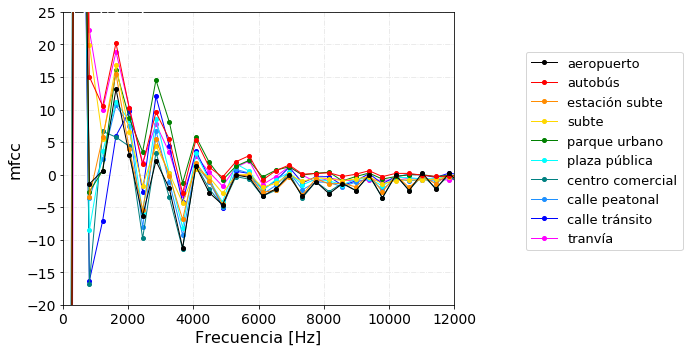

In [141]:
file = 'mfcc.csv'
means, _ = read_analysis(os.path.join(means_dir,file))
stds, _ = read_analysis(os.path.join(stds_dir,file))
plot_features(means=means,stds=stds,labels=labels, colors=tut18_colors,xlim=[0,12000],ylim=[-20,25],fig_name=file.split('.')[0],legend_lim=[0,10])

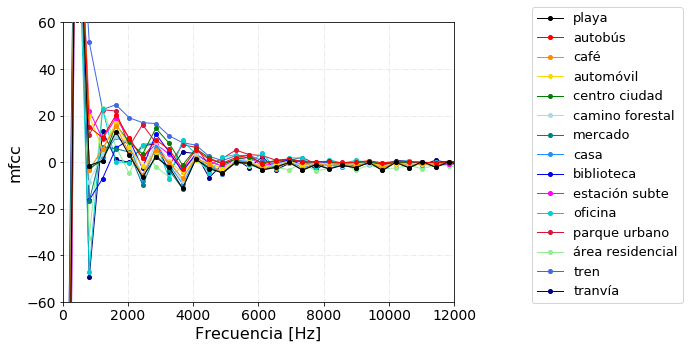

In [144]:
file = 'mfcc.csv'
means, _ = read_analysis(os.path.join(means_dir,file))
stds, _ = read_analysis(os.path.join(stds_dir,file))
plot_features(means=means,stds=stds,labels=labels, colors=tut17_colors,xlim=[0,12000],ylim=[-60,60],fig_name=file.split('.')[0],legend_lim=[10,25])

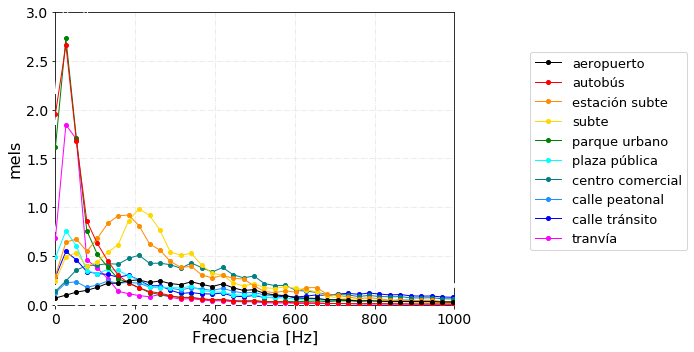

In [142]:
file = 'mels.csv'
means, _ = read_analysis(os.path.join(means_dir,file))
stds, _ = read_analysis(os.path.join(stds_dir,file))
plot_features(means=means,stds=stds,labels=labels, colors=tut18_colors,xlim=[0,1000],ylim=[0,3],fig_name=file.split('.')[0],legend_lim=[0,10])

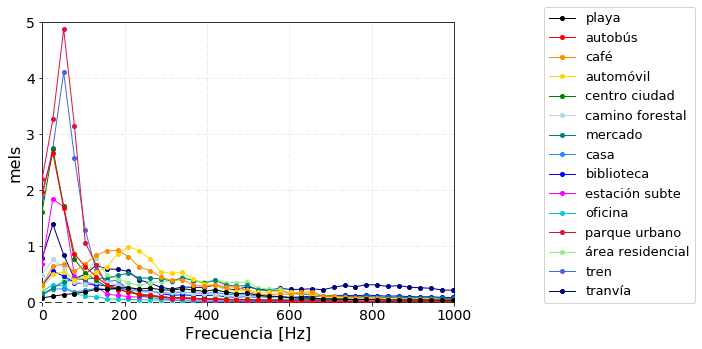

In [145]:
file = 'mels.csv'
means, _ = read_analysis(os.path.join(means_dir,file))
stds, _ = read_analysis(os.path.join(stds_dir,file))
plot_features(means=means,stds=stds,labels=labels, colors=tut17_colors,xlim=[0,1000],ylim=[0,5],fig_name=file.split('.')[0],legend_lim=[10,25])

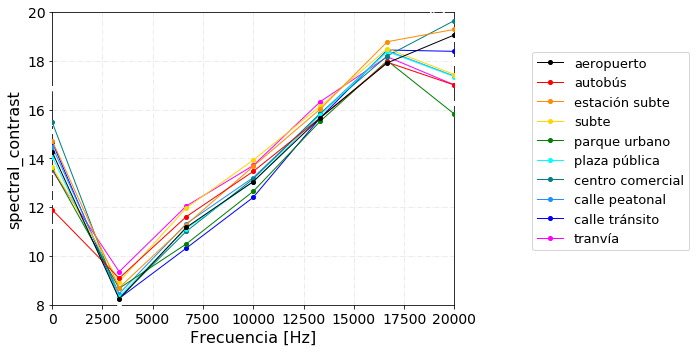

In [143]:
file = 'spectral_contrast.csv'
means, _ = read_analysis(os.path.join(means_dir,file))
stds, _ = read_analysis(os.path.join(stds_dir,file))
plot_features(means=means,stds=stds,labels=labels, colors=tut18_colors,xlim=[0,20000],ylim=[8,20],fig_name=file.split('.')[0],legend_lim=[0,10])

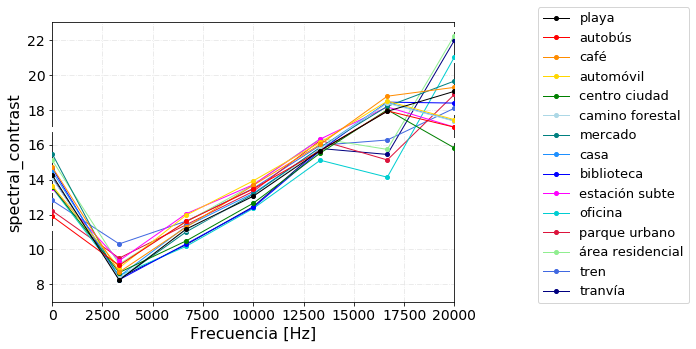

In [146]:
file = 'spectral_contrast.csv'
means, _ = read_analysis(os.path.join(means_dir,file))
stds, _ = read_analysis(os.path.join(stds_dir,file))
plot_features(means=means,stds=stds,labels=labels, colors=tut17_colors,xlim=[0,20000],ylim=[7,23],fig_name=file.split('.')[0],legend_lim=[10,25])